# Custom Models in pycalphad

M.E. Trybula, T. Gancarz, W. Gąsior, Density, surface tension and viscosity of liquid binary Al-Zn and ternary Al-Li-Zn alloys, Fluid Phase Equilibria, Volume 421, 2016, Pages 39-48, ISSN 0378-3812, http://dx.doi.org/10.1016/j.fluid.2016.03.013.
(http://www.sciencedirect.com/science/article/pii/S0378381216301418)

Władysław Gąsior, "Viscosity modeling of binary alloys: Comparative studies",
        Calphad, Volume 44, 2014, Pages 119-128, ISSN 0364-5916,
        http://dx.doi.org/10.1016/j.calphad.2013.10.007.

In [1]:
from pycalphad import Model, Database, calculate, variables as v

In [2]:
import pycalphad.io.tdb_keywords
pycalphad.io.tdb_keywords.TDB_PARAM_TYPES.extend(['ETA', 'TG'])

In [3]:
dbf = Database('alcuzr-viscosity.tdb')

In [4]:
from tinydb import where
import sympy
class ViscosityModel(Model):
    """
    Metallic liquid viscosity model.
    Reference: Władysław Gąsior, "Viscosity modeling of binary alloys: Comparative studies",
        Calphad, Volume 44, 2014, Pages 119-128, ISSN 0364-5916,
        http://dx.doi.org/10.1016/j.calphad.2013.10.007.
    """
    def build_phase(self, dbe):
        super(ViscosityModel, self).build_phase(dbe)
        self.viscosity = self.build_viscosity(dbe)

    def build_viscosity(self, dbe):
        if self.phase_name != 'LIQUID':
            raise ValueError('Viscosity is only defined for LIQUID phase')
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        eta_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == 'ETA') & \
            (where('constituent_array').test(self._array_validity))
        )
        eta = self.redlich_kister_sum(phase, param_search, eta_param_query)
        liquid_mod = Model(dbe, self.components, self.phase_name)
        del liquid_mod.models['ref']
        del liquid_mod.models['idmix']
        excess_entropy = liquid_mod.entropy
        self.excess_entropy = excess_entropy
        ks = 2
        result = eta * (1 - ks * excess_entropy / v.R)
        return result

    @property
    def viscous_activation_energy(self):
        return v.R * sympy.log(self.viscosity).diff(v.T) * -(v.T**2)

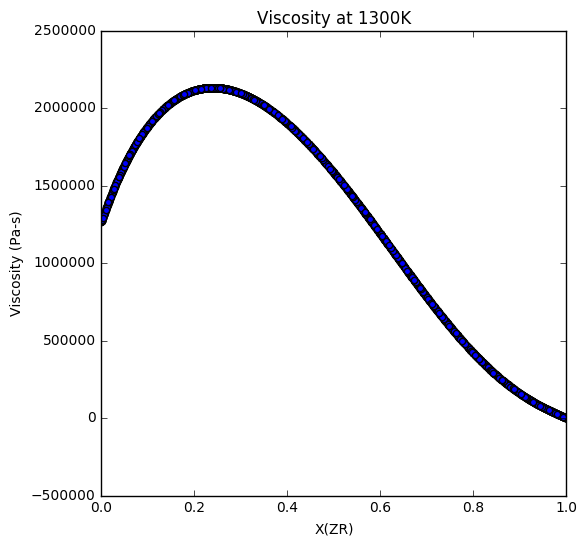

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
mod = ViscosityModel(dbf, ['CU', 'ZR'], 'LIQUID')
temp = 1300
res = calculate(dbf, ['CU', 'ZR'], 'LIQUID', P=101325, T=temp,
                model=mod, output='viscosity')

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.scatter(res.X.sel(component='ZR'), res.viscosity.values)
ax.set_xlabel('X(ZR)')
ax.set_ylabel('Viscosity (Pa-s)')
ax.set_xlim((0,1))
ax.set_title('Viscosity at {}K'.format(temp));